In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")
sns.set_context("notebook")
## sns.set_theme()

In [5]:
%pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [6]:
from Bio import Entrez

# Project Overview

Source : [Analyzing COVID RNA sequences with Python](https://www.youtube.com/watch?v=3qYo9eFxyDY&ab_channel=Dataquest)

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


- 每一列是一個RNA序列的meta data
- 我們會從中選擇我們想dig more的序列，然後下載之

# Loading the metadata

In [7]:
ncbi_dataset = "/content/gdrive/MyDrive/1_DataScience/3_DataQuest/Projects/ncbi_datasets.csv"
metadata = pd.read_csv(ncbi_dataset)
print(metadata.shape) ## 8十幾萬筆RNA meta data
metadata.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(847791, 16)


,Nucleotide Accession,Species Taxonomy Id,Species Name,Virus Genus,Virus Family,Isolate Name,Nucleotide Length,Sequence Type,Nuc Completeness,Geo Location,US State,Host Name,Host Taxonomy ID,Collection Date,BioProject,BioSample
0,NC_045512.2,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,Wuhan-Hu-1,29903,RefSeq,complete,Asia; China,NaN,NaN,9606,2019-12,PRJNA485481,NaN
1,OM487257.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/USA/UT-UPHL-220129247957/2021,29815,GenBank,complete,North America; USA,NaN,NaN,9606,2021-12-23,PRJNA614995,SAMN25559487


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847791 entries, 0 to 847790
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Nucleotide Accession  847791 non-null  object 
 1   Species Taxonomy Id   847791 non-null  int64  
 2   Species Name          847791 non-null  object 
 3   Virus Genus           847791 non-null  object 
 4   Virus Family          847791 non-null  object 
 5   Isolate Name          609653 non-null  object 
 6   Nucleotide Length     847791 non-null  int64  
 7   Sequence Type         847791 non-null  object 
 8   Nuc Completeness      847791 non-null  object 
 9   Geo Location          847720 non-null  object 
 10  US State              0 non-null       float64
 11  Host Name             0 non-null       float64
 12  Host Taxonomy ID      847791 non-null  int64  
 13  Collection Date       847595 non-null  object 
 14  BioProject            611783 non-null  object 
 15  

In [9]:
## 日期有這些不同長度的代表，若只寫2020，則轉datetime時，default會變成2020-01-01
metadata["date_len"] = [ len(str(c)) for c in metadata["Collection Date"] ]
display(metadata.groupby("date_len").apply(lambda group: group["Collection Date"].iloc[0]))
metadata.drop("date_len", axis=1, inplace=True)

date_len
3            NaN
4           2020
7        2019-12
10    2021-12-23
dtype: object

In [10]:
## 將日期轉為datetime obj
metadata["Collection Date"] = pd.to_datetime(metadata["Collection Date"] )

In [11]:
## 將欄名轉小寫，以underscore取代space
metadata.columns = [ c.lower().replace(" ","_") for c in metadata.columns ]
metadata.head(2)

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample
0,NC_045512.2,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,Wuhan-Hu-1,29903,RefSeq,complete,Asia; China,NaN,NaN,9606,2019-12-01,PRJNA485481,NaN
1,OM487257.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/USA/UT-UPHL-220129247957/2021,29815,GenBank,complete,North America; USA,NaN,NaN,9606,2021-12-23,PRJNA614995,SAMN25559487


# Exploratory data analysis

- geo_location欄中同時包含了continent、country，有的還包含了city
- 有些date只有年月，轉datetime時會default為1日

In [12]:
metadata["geo_location"].value_counts()

Europe; United Kingdom:England                       223529
North America; USA                                    72087
North America; USA: California                        49000
North America; USA: Florida                           30146
North America; USA: Minnesota                         27418
                                                      ...  
Asia; West Bank: Qalqlieh                                 1
North America; USA: Contra Costa, ID                      1
North America; USA: Pennsylvania, East Greenville         1
North America; USA: Louisiana, Arabi                      1
Europe; Netherlands:Berlicum                              1
Name: geo_location, Length: 1771, dtype: int64

In [13]:
metadata["continent"] = metadata["geo_location"].str.split(";").str[0]
metadata["continent"].value_counts(dropna=False)

North America    571069
Europe           254520
Oceania           10603
Asia               8581
Africa             2192
South America       755
NaN                  71
Name: continent, dtype: int64

In [14]:
metadata["country"] = metadata["geo_location"].str.split(";").str[1].str.split(":").str[0]
metadata["country"].value_counts(dropna=False)

 USA               568697
 United Kingdom    239525
 Slovakia           11263
 Australia           9927
 Japan               2850
                    ...  
 Belgium                2
 Cambodia               2
 Zambia                 1
 Nepal                  1
 Belarus                1
Name: country, Length: 93, dtype: int64

## continent

In [15]:
## 每個continent的第1個收集的RNA Sequence
metadata.groupby("continent").apply(lambda x: x.sort_values("collection_date").iloc[0] )

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample,continent,country
continent,,,,,,,,,,,,,,,,,,
Africa,OL336607.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/MLI/M00960/2020,29890,GenBank,complete,Africa; Mali,NaN,NaN,9606,2020-02-06,NaN,NaN,Africa,Mali
Asia,NC_045512.2,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,Wuhan-Hu-1,29903,RefSeq,complete,Asia; China,NaN,NaN,9606,2019-12-01,PRJNA485481,NaN,Asia,China
Europe,OU393175.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,NaN,29890,GenBank,complete,Europe; United Kingdom:England,NaN,NaN,9606,2020-01-01,PRJEB37886,SAMEA9354774,Europe,United Kingdom
North America,OL467832.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/USA/hCoV_19_USA_ID_IVREF_6520...,29831,GenBank,complete,"North America; USA: Bingham, ID",NaN,NaN,9606,2020-01-01,NaN,NaN,North America,USA
Oceania,MW320919.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/AUS/VIC16874/2020,29790,GenBank,complete,Oceania; Australia: Victoria,NaN,NaN,9606,2020-01-01,NaN,SAMN16975285,Oceania,Australia
South America,MZ477858.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/BRA/PR-HF441/2020,29779,GenBank,complete,South America; Brazil: Parana,NaN,NaN,9606,2020-01-01,NaN,NaN,South America,Brazil


## RNA length

- 有一筆長度只有2千多的outlier，但nuc_completeness顯示為complete，故可能只是個typo，少key個零之類的。

In [16]:
metadata["nucleotide_length"].value_counts()

29903    80506
29884    76557
29890    54662
29782    27722
29763    19786
         ...  
29419        1
29925        1
28996        1
29492        1
2859         1
Name: nucleotide_length, Length: 482, dtype: int64

In [17]:
metadata["nucleotide_length"].describe()

count    847791.000000
mean      29825.747932
std          69.937482
min        2859.000000
25%       29786.000000
50%       29819.000000
75%       29884.000000
max       30018.000000
Name: nucleotide_length, dtype: float64

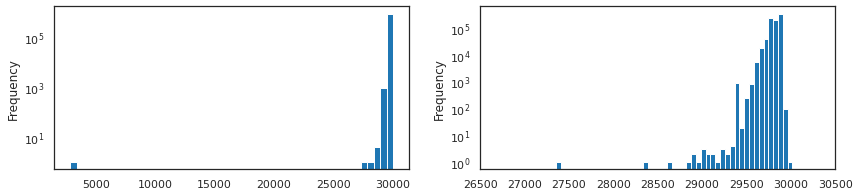

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14,3))
metadata["nucleotide_length"].plot(kind="hist", logy=True, bins=50, ax=ax[0])
metadata["nucleotide_length"].plot(kind="hist", logy=True, xlim=(26500, 30500), bins=500, ax=ax[1])
plt.show()

In [19]:
metadata[ metadata["nucleotide_length"]==metadata["nucleotide_length"].min() ]

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample,continent,country
847723,LR877184.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,NaN,2859,GenBank,complete,"Europe; Sweden:Stockholm, Sweden",NaN,NaN,9606,2020-04-26,PRJEB39632,SAMEA7098098,Europe,Sweden


## sample amount by year-month

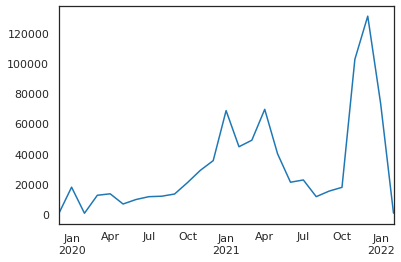

In [20]:
sample_month = metadata["collection_date"].dt.to_period('M')  
sample_month.value_counts().sort_index().plot()

- 可看到RNA定序數量在2021年及年末時增加。

# Identifying sequences to download

In [21]:
# extract第一個被定序的RNA id
metadata[ metadata["sequence_type"]=="RefSeq"] ## 第一個被定序的稱為RefSeq

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample,continent,country
0,NC_045512.2,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,Wuhan-Hu-1,29903,RefSeq,complete,Asia; China,NaN,NaN,9606,2019-12-01,PRJNA485481,NaN,Asia,China


In [22]:
# 接著找到delta及omicron的id (isolate_name即為variant)
# delta
metadata[ metadata["isolate_name"].str.contains(r"[dD]elta").fillna(False) ]

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample,continent,country
85804,OM108163.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/CHN/Delta-3/2021,29860,GenBank,complete,Asia; China: Beijing,NaN,NaN,9606,2021-08-14,NaN,NaN,Asia,China
85948,OM061695.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/CHN/Delta-1/2021,29858,GenBank,complete,Asia; China: Beijing,NaN,NaN,9606,2021-08-10,NaN,NaN,Asia,China
251375,OK091006.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,"SARS-CoV-2/human/JPN/SARS-CoV-2, B.1.617.2 lin...",29836,GenBank,complete,Asia; Japan,NaN,NaN,9606,2021-08-24,NaN,NaN,Asia,Japan
665095,OM108132.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/CHN/Delta-2/2021,29858,GenBank,complete,Asia; China: Beijing,NaN,NaN,9606,2021-08-11,NaN,NaN,Asia,China


In [23]:
# omicron
metadata[ metadata["isolate_name"].str.contains(r"[Oo]micron").fillna(False) ]

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample,continent,country
806923,OM095411.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/CHN/Omicron-1/2021,29788,GenBank,complete,Asia; China: Beijing,NaN,NaN,9606,2021-12-08,NaN,NaN,Asia,China


In [24]:
## 此4個RNA分別為 RefSeq、北美、delta、omicron
nucleodite_ids = ["NC_045512.2", "OL467832.1", "OM061695.1", "OM095411.1" ] 
human_names = ["ref", "base", "delta", "omicron"]

In [25]:
selected_sequences = metadata[ metadata["nucleotide_accession"].isin(nucleodite_ids) ]
selected_sequences

,nucleotide_accession,species_taxonomy_id,species_name,virus_genus,virus_family,isolate_name,nucleotide_length,sequence_type,nuc_completeness,geo_location,us_state,host_name,host_taxonomy_id,collection_date,bioproject,biosample,continent,country
0,NC_045512.2,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,Wuhan-Hu-1,29903,RefSeq,complete,Asia; China,NaN,NaN,9606,2019-12-01,PRJNA485481,NaN,Asia,China
85948,OM061695.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/CHN/Delta-1/2021,29858,GenBank,complete,Asia; China: Beijing,NaN,NaN,9606,2021-08-10,NaN,NaN,Asia,China
254609,OL467832.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/USA/hCoV_19_USA_ID_IVREF_6520...,29831,GenBank,complete,"North America; USA: Bingham, ID",NaN,NaN,9606,2020-01-01,NaN,NaN,North America,USA
806923,OM095411.1,2697049,Severe acute respiratory syndrome coronavirus 2,Betacoronavirus,Coronaviridae,SARS-CoV-2/human/CHN/Omicron-1/2021,29788,GenBank,complete,Asia; China: Beijing,NaN,NaN,9606,2021-12-08,NaN,NaN,Asia,China


# Downloading the sequences

[biopython reference](https://biopython-cn.readthedocs.io/zh_CN/latest/cn/chr09.html)

[Entrez cod help](https://www.ncbi.nlm.nih.gov/books/NBK25501/)

In [27]:
from Bio import Entrez
Entrez.email = "hsinling1107@gail.com" # 每次你下載序列的時候，會把你的email傳給nih讓他們知道你是誰，並在有問題的時候寄mail給你

In [109]:
## Entrez Info(所有數據庫名稱)
handle = Entrez.einfo()
result = Entrez.read(handle)
result

{'DbList': ['pubmed', 'protein', 'nuccore', 'ipg', 'nucleotide', 'structure', 'genome', 'annotinfo', 'assembly', 'bioproject', 'biosample', 'blastdbinfo', 'books', 'cdd', 'clinvar', 'gap', 'gapplus', 'grasp', 'dbvar', 'gene', 'gds', 'geoprofiles', 'homologene', 'medgen', 'mesh', 'nlmcatalog', 'omim', 'orgtrack', 'pmc', 'popset', 'proteinclusters', 'pcassay', 'protfam', 'pccompound', 'pcsubstance', 'seqannot', 'snp', 'sra', 'taxonomy', 'biocollections', 'gtr']}

In [ ]:
## 個別數據庫 Info
handle = Entrez.einfo(db="nucleotide")
result = Entrez.read(handle)
result

In [113]:
resp_obj = Entrez.esearch(db="nucleotide", term="OM061695.1", retmax="1")  # retmax 回傳1個id
print("resp_obj type:" , type(resp_obj))
result = Entrez.read(resp_obj)
  ## esearch()回傳一個XML格式的http response object
  ## read()回傳一個dictionary，其中包含match到query term的UID列表- "IdList"
print("result type:", type(result))
result

resp_obj type: <class 'http.client.HTTPResponse'>
result type: <class 'Bio.Entrez.Parser.DictionaryElement'>


{'Count': '1', 'RetMax': '1', 'RetStart': '0', 'IdList': ['2171483369'], 'TranslationSet': [], 'QueryTranslation': ''}

In [119]:
seq =Entrez.efetch(db="nucleotide", id=result["IdList"][0], rettype="fasta", retmode="text") # return type也可為gb(genbank)或xml格式等
print("seq type:", type(seq))
seq.read() # str format

seq type: <class '_io.TextIOWrapper'>


'>OM061695.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Delta-1/2021, complete genome\nATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA\nCGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC\nTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTT\nTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTC\nCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTAC\nGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGG\nCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGAT\nGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTC\nGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCT\nTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTA\nGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTG\nTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGG\nCCCTGATGGCTACCC

In [ ]:
## gene bank format
seq =  Entrez.efetch(db="nucleotide", id=result["IdList"][0], rettype="gb", retmode="text")
print(seq.read())

## 取得序列

In [121]:
def download_sequence(id_code):
  resp = Entrez.esearch(db="nucleotide", term=id_code, retmax="1") ## http_resp obj
  result = Entrez.read(resp)  # Entrez.Parser.DictionaryElement obj
  handle = Entrez.efetch(db="nucleotide", id = result["IdList"][0], rettype="fasta", retmode="text") ## text wrapper obj
  return handle.read()  ## fasta (str format)

In [122]:
sequence_data = {}
for id in nucleodite_ids:
  sequence_data[id] =  { "fasta":download_sequence(id) }

In [64]:
sequence_data

{'NC_045512.2': {'fasta': '>NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome\nATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA\nCGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC\nTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTG\nTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTC\nCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTAC\nGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGG\nCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGAT\nGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTC\nGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCT\nTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTA\nGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTG\nTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGG\nCCCTGATGGCT

# Parsing RNA sequences

In [65]:
from Bio import SeqIO ## SeqIO含有fasta parser
import io

In [132]:
resp_obj = Entrez.esearch(db="nucleotide", term="OM061695.1", retmax="1")  # http resp
result = Entrez.read(resp_obj)   # Entrez.Parser的dictionary (內有IdList)
txt_wrapper = Entrez.efetch(db="nucleotide", id = result["IdList"][0], rettype="fasta", retmode="text") # text wrapper
txt_fasta = txt_wrapper.read() # fasta in str format
f = io.StringIO(txt_fasta) # fake file
parsed = SeqIO.parse(handle = f, format = "fasta") # Bio.SeqIO.FastaIO.FastaIterator
parsed_unwrap = [ i for i in parsed ][0] # Bio.SeqRecord.SeqRecord
parsed_unwrap

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...ACA'), id='OM061695.1', name='OM061695.1', description='OM061695.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/CHN/Delta-1/2021, complete genome', dbxrefs=[])

In [138]:
print(type(parsed_unwrap.seq))
parsed_unwrap.seq

<class 'Bio.Seq.Seq'>


Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...ACA')

## 解析RNA序列

- 因sequence常從disc中取得，故biopython要parse fasta format只能work with file

In [141]:
for key, value in sequence_data.items():
  f = io.StringIO(value["fasta"])  ## 將字串存為偽文件，因為要用biopython來解析，但biopython只work with file
  sequence_data[key]["parsed"] =  list(SeqIO.parse(f, "fasta"))[0] ## 為Bio.SeqRecord obj

經SeqIO解析後回傳一個Bio.SeqIO.FastaIO.FastaIterator obj

透過list取出後為一Bio.SeqRecord obj包含:
- seq: 序列本身
- id: 序列主id(accession number)
- name: 序列id(可以是accession number或clone名，類似Genbank locus id)
- description: 序列描述
- dbxrefs: 數據庫cross-references


In [82]:
file = io.StringIO(sequence_data['NC_045512.2']["fasta"]) 
[ i for i in SeqIO.parse(file, "fasta") ]

[SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='NC_045512.2', name='NC_045512.2', description='NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome', dbxrefs=[])]

In [143]:
sequence_data

{'NC_045512.2': {'fasta': '>NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome\nATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA\nCGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAAC\nTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTG\nTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTC\nCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTAC\nGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGG\nCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGAT\nGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTC\nGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCT\nTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTA\nGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTG\nTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGG\nCCCTGATGGCT

In [142]:
## 此4個RNA分別為 RefSeq、北美、delta、omicron
## ["NC_045512.2", "OL467832.1", "OM061695.1", "OM095411.1" ]
sequence_data["NC_045512.2"]["parsed"]

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA'), id='NC_045512.2', name='NC_045512.2', description='NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome', dbxrefs=[])

# Aligning RNA sequences

In [144]:
from Bio import Align

In [145]:
aligner = Align.PairwiseAligner()
aligner.algorithm

'Needleman-Wunsch'

In [146]:
score = aligner.score(sequence_data["NC_045512.2"]["parsed"].seq, sequence_data["OM061695.1"]["parsed"].seq)

In [148]:
print(score)
print(score/len(sequence_data["NC_045512.2"]["parsed"].seq))

29818.0
0.9971574758385446


- omicron株和中國最早的病毒株序列上仍有99.7%的相似度

# Checking alignment across variants

In [149]:
## 製一matrix，以存放此4病毒株兩兩相比的結果
comparisons = np.zeros((4,4))
comparisons

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [153]:
nucleodite_ids = ["NC_045512.2", "OL467832.1", "OM061695.1", "OM095411.1" ] 
human_names = ["ref", "base", "delta", "omicron"]

for i in range(0,4):
  for j in range(0,4):
    score = aligner.score(sequence_data[ nucleodite_ids[i] ]["parsed"].seq, 
                sequence_data[ nucleodite_ids[j] ]["parsed"].seq )
    comparisons[i, j] = score

In [154]:
comparisons_df = pd.DataFrame(comparisons, columns=human_names, index=human_names)
comparisons_df

,ref,base,delta,omicron
ref,29903.0,29820.0,29818.0,29725.0
base,29820.0,29831.0,29775.0,29722.0
delta,29818.0,29775.0,29858.0,29688.0
omicron,29725.0,29722.0,29688.0,29788.0


In [155]:
## 取第1欄，除以ref的值計算與ref的相似度
comparisons_df.iloc[:, 0]/29903

ref        1.000000
base       0.997224
delta      0.997157
omicron    0.994047
Name: ref, dtype: float64

- 可以看到base(北美區)約在ref 2個月後，與ref的相似度仍很高
- delta variant相似度下降但未降太多
- 而omicron變異較多

整體而言，隨時間過去virus變異性增加，但比例上並沒真的突變很多。

# Showing sequence mismatches

In [164]:
## 比較ref及delta的變異位置
seq1 = sequence_data["NC_045512.2"]["parsed"].seq  # ref
seq2 = sequence_data["OM061695.1"]["parsed"].seq  # delta

In [158]:
delta_alignments = aligner.align(seq1, seq2) ## 回傳一個list
delta_alignments

<class 'Bio.Align.PairwiseAlignments'>


In [161]:
delta_alignment = delta_alignments[0]
delta_alignment.shape ## 顯示兩個序列中有overlap的片段

(2, 29943)

In [163]:
delta_alignment.aligned ## 回傳((seq1有overlap到seq2的片段們), (seq2有overlap到seq1的片段們))

(((0, 209),
  (210, 212),
  (212, 240),
  (241, 1047),
  (1048, 1273),
  (1274, 1276),
  (1276, 3036),
  (3037, 3038),
  (3038, 4180),
  (4181, 6401),
  (6402, 7123),
  (7123, 7124),
  (7125, 8985),
  (8986, 8989),
  (8989, 9052),
  (9053, 9054),
  (9054, 10028),
  (10028, 10029),
  (10030, 10506),
  (10507, 11116),
  (11117, 11200),
  (11201, 11331),
  (11332, 11333),
  (11333, 14407),
  (14408, 14409),
  (14409, 15450),
  (15450, 15451),
  (15452, 16465),
  (16466, 19219),
  (19220, 19221),
  (19221, 21617),
  (21618, 21986),
  (21987, 22028),
  (22029, 22030),
  (22033, 22035),
  (22037, 22916),
  (22917, 22918),
  (22918, 22994),
  (22995, 22996),
  (22996, 23402),
  (23403, 23603),
  (23604, 24409),
  (24410, 24411),
  (24411, 25087),
  (25088, 25090),
  (25090, 25351),
  (25352, 25353),
  (25353, 25468),
  (25469, 26423),
  (26424, 26425),
  (26425, 26766),
  (26767, 26768),
  (26768, 27526),
  (27527, 27637),
  (27637, 27639),
  (27640, 27751),
  (27752, 27873),
  (27874, 27876)

In [195]:
i = 0
for alignments in zip(delta_alignment.aligned[0], delta_alignment.aligned[1]):
  if i < 10:
    print(alignments)
    i += 1

((0, 209), (0, 209))
((210, 212), (209, 211))
((212, 240), (212, 240))
((241, 1047), (241, 1047))
((1048, 1273), (1048, 1273))
((1274, 1276), (1273, 1275))
((1276, 3036), (1276, 3036))
((3037, 3038), (3036, 3037))
((3038, 4180), (3038, 4180))
((4181, 6401), (4181, 6401))


In [ ]:
## check有哪些片段不match
seq1_end = None
seq2_end = None
for alignments in zip(delta_alignment.aligned[0], delta_alignment.aligned[1]):
  if seq1_end and seq2_end:  ## 第1輪不print，因第1輪沒有mismatch
    seq1_mismatch = seq1[ seq1_end: alignments[0][0] ] # seq1前align片段尾到下一個align片段開頭(即mismatch的序列)
    seq2_mismatch = seq2[ seq2_end: alignments[1][0] ] # seq2前align片段尾到下一個align片段開頭
    print("1: {}".format(seq1_mismatch))
    print("2: {}".format(seq2_mismatch))
  seq1_end = alignments[0][1]  ## 找到alignment的end
  seq2_end = alignments[1][1]


In [200]:
from IPython.display import HTML

# Color coding mismatches

In [201]:
def color_print(s, color="black"):
  return "<span style='color:{}'> {} </span>".format(color, s)

In [203]:
seq1_end = None
seq2_end = None
display_seq = []

for alignments in zip(delta_alignment.aligned[0], delta_alignment.aligned[1]):
  if seq1_end and seq2_end:  
    seq1_mismatch = seq1[ seq1_end: alignments[0][0] ] # seq1前align片段尾到下一個align片段開頭(即mismatch的序列)
    seq2_mismatch = seq2[ seq2_end: alignments[1][0] ] # seq2前align片段尾到下一個align片段開頭
    if len(seq2_mismatch) == 0:  ## seq2 deletion
      display_seq.append(color_print(seq1_mismatch, "red"))
    elif len(seq1_mismatch) == 0: ## seq2 insertion
      display_seq.append(color_print(seq2_mismatch, "green"))
    else: ## mismatch
      display_seq.append(color_print(seq2_mismatch, "blue"))
    
  display_seq.append(seq1[ alignments[0][0]:alignments[0][1]  ]) ## 原來有match的序列
    
  seq1_end = alignments[0][1]  ## 找到alignment的end
  seq2_end = alignments[1][1]

In [209]:
print(type(display_seq[0]))
print(type(display_seq[1]))
display_seq[:10]

<class 'Bio.Seq.Seq'>
<class 'str'>


[Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...CGT'),
 "<span style='color:red'> G </span>",
 Seq('TT'),
 "<span style='color:green'> T </span>",
 Seq('GCAGCCGATCATCAGCACATCTAGGTTT'),
 "<span style='color:blue'> T </span>",
 Seq('GTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAG...AAA'),
 "<span style='color:blue'> T </span>",
 Seq('AAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCC...TTT'),
 "<span style='color:red'> G </span>"]

In [213]:
## display
display_seq = [ str(i) for i in display_seq ]## 先轉string
display(HTML("<br>".join(display_seq))) ## 每段match/mismatch序列之間加一個斷行符，並把整個list join成一個字串

In [218]:
display_seq = [ str(i) for i in display_seq ]
display(HTML("".join(display_seq)))

# Next Steps

- 可轉成codon，找出其encode的protein，決定其在variant間的變化為何
- 可觀察其它variant，mutation pattern如何隨時間變化
- 可觀察常見的del insert subsitution部位，看看哪個變化較快/慢
- 